# End to End BSS

In [ ]:
%load_ext autoreload
%autoreload 2

## train

In [27]:
import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
import numpy as np
import tqdm
from argparse import ArgumentParser

from model import WaveNet, loss_fn, align
from datasets.datasets import train_dataset, test_dataset
from params import params

lr = 1e-2
batch_size = 256
epoch = 50

device = torch.device('cuda:2')

model = WaveNet(params=params).to(device)
try: 
    model.load_state_dict(torch.load('/home/wyl/projects/_BSS_latent/ckpt/ckpt.pth'))
    print('model loaded')
except:
    print('model does not exist')

train_data = train_dataset()
test_data = test_dataset()
data_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

optimizer = AdamW(model.parameters(), lr=lr, eps=1e-6)

tqdm_epoch = tqdm.notebook.tqdm(range(epoch))

for _ in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for train_data, truth in data_loader:
        train_data = align(train_data.squeeze(1)).to(device)
        truth = align(truth.squeeze(1)).to(device)

        output = model(train_data)
        loss = loss_fn(output, truth)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item() * train_data.shape[0]
        num_items += train_data.shape[0]

    # # Print the averaged training loss so far.
    # tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # # Update the checkpoint after each epoch of training.
    # torch.save(model.state_dict(), '/home/wyl/projects/_BSS_latent/ckpt/ckpt.pth') 
    
    with torch.no_grad():
        
        test_loss = 0.
        test_items = 0
        for test_data, test_truth in test_loader:
            test_data = align(test_data.squeeze(1)).to(device)
            test_truth = align(test_truth.squeeze(1)).to(device)

            output = model(test_data)
            loss = loss_fn(output, test_truth)

            test_loss += loss.item() * train_data.shape[0]
            test_items += train_data.shape[0]

    # print('test loss: {:5f}'.format(test_loss / test_items))
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f},   Test Loss: {:5f}'.format(avg_loss / num_items, test_loss / test_items))
    # Update the checkpoint after each epoch of training.
    torch.save(model.state_dict(), '/home/wyl/projects/_BSS_latent/ckpt/ckpt.pth') 


model loaded


  0%|          | 0/50 [00:00<?, ?it/s]

## evaluate and show

model loaded
torch.Size([10, 3, 512])
torch.Size([10, 3, 512])
torch.Size([3, 512])
torch.Size([3, 512])


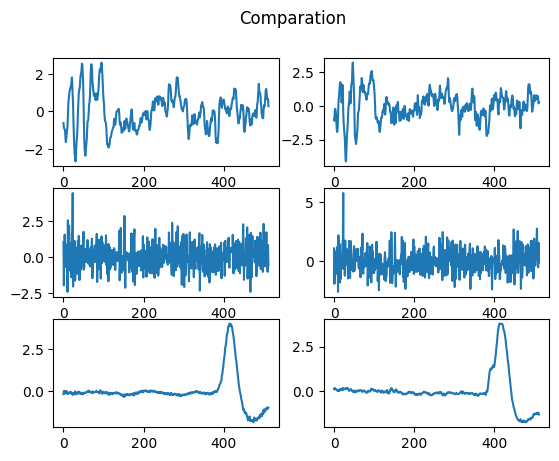

In [24]:
from model import WaveNet
import matplotlib.pyplot as plt
from datasets.datasets import train_dataset, test_dataset
from torch.utils.data import DataLoader, RandomSampler
from params import params

model = WaveNet(params)
try: 
    model.load_state_dict(torch.load('/home/wyl/projects/_BSS_latent/ckpt/ckpt.pth'))
    print('::: model loaded :::')
except:
    print('::: ckpt does not exist :::')

seed = torch.manual_seed(3693)
train_sampler = RandomSampler(train_dataset(), replacement=False, num_samples=100)
test_sampler = RandomSampler(test_dataset(), replacement=False, num_samples=100)
train_loader = DataLoader(train_dataset(), batch_size=10, sampler=train_sampler)
test_loader = DataLoader(test_dataset(), batch_size=10, shuffle=test_sampler)

data, truth = next(iter(train_loader))

randint = torch.randint(0, 10, (1,))
data = data.squeeze(1).to(torch.float32)
truth = truth.squeeze(1).to(torch.float32)

with torch.no_grad():
    output = model(data)

result = output[randint].squeeze(0)
truth = truth[randint].squeeze(0)

# plot
fig, axs = plt.subplots(nrows=3, ncols=2)

axs[0, 0].plot(result[0])
axs[0, 1].plot(truth[0])

axs[1, 0].plot(result[1])
axs[1, 1].plot(truth[1])

axs[2, 0].plot(result[2])
axs[2, 1].plot(truth[2])

fig.suptitle('Comparation')

plt.show()